In [137]:
import re
import time
import math
from joblib import Memory
import spacy
import syllapy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords, words

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV


from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

## Preprocessing

In [133]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('words')

#  Data Loading & Splitting
df = pd.read_json('../data/Sarcasm_Headlines_Dataset_v2.json', lines=True)
X = df['headline']
y = df['is_sarcastic']


# # Function to split long headlines into segments based on a word threshold.
def split_headline(headline, word_threshold=10):
    """
    Split a headline into segments if it contains more than word_threshold words.
    Otherwise, return the original headline as a single segment.
    """
    words = headline.split()
    if len(words) <= word_threshold:
        return [headline]
    # Option 1: Split headline into segments of exactly word_threshold words each.
    segments = [" ".join(words[i:i+word_threshold]) for i in range(0, len(words), word_threshold)]
    # Option 2: use punctuation to split into more natural segments.
    # segments = re.split(r'[.!?]+', headline)
    # segments = [seg.strip() for seg in segments if seg.strip()]
    return segments

# # Create a new dataframe with segmented headlines.
# segmented_headlines = []
# labels = []
# for idx, row in df.iterrows():
#     headline = row['headline']
#     label = row['is_sarcastic']
#     segments = split_headline(headline, word_threshold=10)  # Adjust threshold as desired.
#     segmented_headlines.extend(segments)
#     # Assign the same label to each segment from the original headline.
#     labels.extend([label] * len(segments))

# seg_df = pd.DataFrame({
#     "headline": segmented_headlines,
#     "is_sarcastic": labels
# })

# print("Segmented dataset shape:", seg_df.shape)
# print(seg_df.isnull().sum())
# print("Sarcastic count:", seg_df[seg_df['is_sarcastic'] == 1].shape[0])
# print("Non-sarcastic count:", seg_df[seg_df['is_sarcastic'] == 0].shape[0])

# # Now, split the segmented dataset into train/test sets (80/20 split)
# X = seg_df['headline']
# y = seg_df['is_sarcastic']


# Split data: 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50, stratify=y)

print("Dataset missing values:")
print("Sarcastic count:", df[df['is_sarcastic'] == 1].shape[0])
print("Non-sarcastic count:", df[df['is_sarcastic'] == 0].shape[0])

# Preprocessing and NLP Setup
stop_words = set(stopwords.words('english'))
correct_words = set(words.words())
with open('../data/dale-chall-3000-words.txt', 'r') as f:
    dale_chall_easy_words = set(f.read().split())

nlp = spacy.load('en_core_web_md') 

def clean_text(text):
    """Remove URLs, HTML tags, and normalize whitespace."""
    text = str(text)
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def clean_texts(X):
    return np.array([clean_text(x) for x in X])

cleaner_transformer = FunctionTransformer(clean_texts, validate=False)


[nltk_data] Downloading package punkt to /Users/mikhil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mikhil/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mikhil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/mikhil/nltk_data...
[nltk_data]   Package words is already up-to-date!


Dataset missing values:
Sarcastic count: 13634
Non-sarcastic count: 14985


## Handcrafted features

In [134]:
# Define additional lists for linguistic features
negation_words = set(["not", "no", "never", "none", "nobody", "nothing", "neither", "nowhere", 
                      "hardly", "scarcely", "barely", "don't", "doesn't", "didn't", "won't", 
                      "wouldn't", "can't", "couldn't", "shouldn't"])

intensifiers = set(["really", "very", "extremely", "so", "incredibly", "absolutely", "utterly"])
downtoners = set(["somewhat", "rather", "slightly", "mildly"])
contrast_markers = set(["but", "however", "although", "though", "yet", "still"])
# Function to compute Semantic Imbalance Rate (SIR)
def compute_sir(doc):
    # We filter to alphabetic tokens that have vectors.
    tokens = [token for token in doc if token.is_alpha and token.has_vector]
    N = len(tokens)
    if N < 2:
        return 0.0  # Not enough tokens to compute pairwise similarity.
    
    total_max_sim = 0.0
    for i, token in enumerate(tokens):
        max_sim = 0.0
        for j, other in enumerate(tokens):
            if i != j:
                sim = token.similarity(other)
                if sim > max_sim:
                    max_sim = sim
        total_max_sim += max_sim
    sir = total_max_sim / N
    return sir
def extract_features(X):
    """Extract linguistic features from each headline in X, including sentiment-related features for sarcasm detection."""
    features = []
    for headline in X:
        headline = str(headline)  
        doc = nlp(headline)
        tokens = [token.text for token in doc]
        total_words = len(tokens)
        if total_words == 0:
            features.append([0] * 30)  # Adjusted to 30 features total
            continue

        unique_words = len(set(tokens))
        fdist = FreqDist(tokens)
        word_freq = np.array(list(fdist.values())) / total_words
        entropy = -np.sum([p * math.log2(p) for p in word_freq])
        lexical_diversity = unique_words / total_words

        num_difficult = 0
        syllable_counts = []
        stopword_count = 0
        wrong_word_count = 0
        lengthy_word_count = 0
        two_letter_words = 0
        one_letter_words = 0
        verbs = 0
        adjectives = 0
        nouns = 0

        for token in doc:
            w = token.text
            if w.isalpha():
                syll_count = syllapy.count(w)
                syllable_counts.append(syll_count)
                if len(w) > 2:
                    lengthy_word_count += 1
                if w not in correct_words:
                    wrong_word_count += 1
                if w not in dale_chall_easy_words:
                    num_difficult += 1
            if token.is_stop:
                stopword_count += 1
            if len(w) == 2:
                two_letter_words += 1
            elif len(w) == 1:
                one_letter_words += 1
            if token.pos_ == "VERB":
                verbs += 1
            elif token.pos_ == "ADJ":
                adjectives += 1
            elif token.pos_ == "NOUN":
                nouns += 1

        avg_syllables_per_word = np.mean(syllable_counts) if syllable_counts else 0
        num_sents = len(list(doc.sents))
        avg_sentence_len = total_words / max(1, num_sents)
        percent_difficult = num_difficult / total_words

        # Compute readability scores using simplified formulas
        dale_score = 0.1579 * percent_difficult + 0.0496 * avg_sentence_len
        flesch_score = 206.835 - (1.015 * avg_sentence_len) - (84.6 * avg_syllables_per_word)

        negation_count = sum(1 for token in tokens if token.lower() in negation_words)

        intensifier_count = sum(1 for token in tokens if token.lower() in intensifiers)

        downtoner_count = sum(1 for token in tokens if token.lower() in downtoners)

        exclam_count = headline.count('!')

        question_count = headline.count('?')

        # # Uppercase ratio – how many tokens are all uppercase.
        # uppercase_tokens = sum(1 for token in tokens if token.isupper())
        # uppercase_ratio = uppercase_tokens / total_words

        # Overall headline sentiment using VADER compound score
        vs = analyzer.polarity_scores(headline)
        sentiment = vs['compound']

        # Contrast marker count
        contrast_count = sum(1 for token in tokens if token.lower() in contrast_markers)

        # Average word length (only count alphabetic tokens)
        word_lengths = [len(token) for token in tokens if token.isalpha()]
        avg_word_length = np.mean(word_lengths) if word_lengths else 0

        # Sentiment Polarity Differences
        token_sentiments = [analyzer.polarity_scores(token)['compound'] for token in tokens]
        sentiment_disparity = 0
        if len(token_sentiments) > 1:
            weighted_differences = []
            for i in range(len(token_sentiments)):
                for j in range(i + 1, len(token_sentiments)):
                    weighted_diff = abs(token_sentiments[i] - token_sentiments[j]) * (j - i)
                    weighted_differences.append(weighted_diff)
            if weighted_differences:
                sentiment_disparity = np.mean(weighted_differences)

        # Define thresholds for polarity (VADER recommended thresholds can be around 0.05)
        pos_threshold = 0.05
        neg_threshold = -0.05

        # Explicit incongruity: count transitions between opposite polarities in consecutive tokens.
        explicit_incongruity_count = 0
        for i in range(len(token_sentiments) - 1):
            current = token_sentiments[i]
            nxt = token_sentiments[i + 1]
            current_sign = 'pos' if current > pos_threshold else ('neg' if current < neg_threshold else None)
            nxt_sign = 'pos' if nxt > pos_threshold else ('neg' if nxt < neg_threshold else None)
            if current_sign is not None and nxt_sign is not None and current_sign != nxt_sign:
                explicit_incongruity_count += 1

        # Largest positive subsequence (consecutive positive tokens)
        largest_positive_subsequence = 0
        current_pos = 0
        for s in token_sentiments:
            if s > pos_threshold:
                current_pos += 1
            else:
                largest_positive_subsequence = max(largest_positive_subsequence, current_pos)
                current_pos = 0
        largest_positive_subsequence = max(largest_positive_subsequence, current_pos)

        # Largest negative subsequence (consecutive negative tokens)
        largest_negative_subsequence = 0
        current_neg = 0
        for s in token_sentiments:
            if s < neg_threshold:
                current_neg += 1
            else:
                largest_negative_subsequence = max(largest_negative_subsequence, current_neg)
                current_neg = 0
        largest_negative_subsequence = max(largest_negative_subsequence, current_neg)

        # Largest same polarity sequence (ignoring neutrals; sequence of tokens with same non-neutral polarity)
        largest_same_polarity_sequence = 0
        current_same = 0
        prev_sign = None
        for s in token_sentiments:
            if s > pos_threshold:
                sign = 'pos'
            elif s < neg_threshold:
                sign = 'neg'
            else:
                sign = None
            if sign is None:
                current_same = 0
                prev_sign = None
            elif prev_sign is None or sign == prev_sign:
                current_same += 1
                prev_sign = sign
            else:
                largest_same_polarity_sequence = max(largest_same_polarity_sequence, current_same)
                current_same = 1
                prev_sign = sign
        largest_same_polarity_sequence = max(largest_same_polarity_sequence, current_same)

        # Count of positive and negative words based on token sentiment
        positive_words_count = sum(1 for s in token_sentiments if s > pos_threshold)
        negative_words_count = sum(1 for s in token_sentiments if s < neg_threshold)

        # Lexical polarity: sum of token-level compound sentiment scores (can also use average)
        lexical_polarity = np.sum(token_sentiments)
        # ----------------------------------------------
        
        sir = compute_sir(doc)


        # Append all features (total 30 features)
        features.append([
            entropy,                      # 1. Entropy
            lexical_diversity,            # 2. Lexical Diversity
            dale_score,                   # 3. Dale-Chall Score
            flesch_score,                 # 4. Flesch Reading Ease
            stopword_count,               # 5. Stop Words Count
            wrong_word_count,             # 6. Wrong Words Count
            num_difficult,                # 7. Difficult Words Count
            lengthy_word_count,           # 8. Lengthy Words Count
            two_letter_words,             # 9. Two-Letter Words Count
            one_letter_words,             #10. Single-Letter Words Count
            verbs,                        #11. Verb Count
            adjectives,                   #12. Adjective Count
            nouns,                        #13. Noun Count
            negation_count,               #14. Negation Count
            intensifier_count,            #15. Intensifier Count
            downtoner_count,              #16. Downtoner Count
            exclam_count,                 #17. Exclamation Mark Count
            question_count,               #18. Question Mark Count
            sentiment,                    #19. Headline Sentiment Score
            contrast_count,               #20. Contrast Marker Count
            avg_word_length,              #21. Average Word Length
            sentiment_disparity,          #22. Sentiment Polarity Differences Feature
            explicit_incongruity_count,   #23. Explicit Incongruity Count
            largest_positive_subsequence, #24. Largest Positive Subsequence
            largest_negative_subsequence, #25. Largest Negative Subsequence
            largest_same_polarity_sequence, #26. Largest Same-Polarity Sequence
            positive_words_count,         #27. Count of Positive Words
            negative_words_count,         #28. Count of Negative Words
            lexical_polarity,              #29. Lexical Polarity
            sir,                         #30. Semantic Imbalance Rate (SIR)
        ])
    return np.array(features)

# Wrap the feature extractor for pipeline use
feature_transformer = FunctionTransformer(extract_features, validate=False)


## Full ensemble

In [135]:
# Full Ensemble Classifier (Fixed Parameters from GridSearch)
ensemble_clf = VotingClassifier(
    estimators=[
        ('dt', DecisionTreeClassifier(random_state=42, min_samples_split=50, max_leaf_nodes=150, max_depth=7)),
        ('gb', GradientBoostingClassifier(random_state=42, n_estimators=200, max_depth=7, learning_rate=0.05)),
        ('rf', RandomForestClassifier(random_state=42, n_estimators=100, max_depth=None))
    ],
    voting='hard'
)



pipeline = Pipeline([
    ('clean', cleaner_transformer),
    ('features', feature_transformer),
    ('classifier', ensemble_clf)
])



start_time = time.time()
pipeline.fit(X_train, y_train)
end_time = time.time()
print(f"Final model training time: {end_time - start_time:.2f} seconds")

# Evaluation
def show_metrics(model, X, y, label_str):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    print(f"{label_str} metrics:")
    print("Accuracy = {:.4f}".format(acc))
    print("F1 Score = {:.4f}".format(f1))
    print(classification_report(y, y_pred))
    print("-" * 50)

show_metrics(pipeline, X_train, y_train, "Final Model Training Set")
show_metrics(pipeline, X_test, y_test, "Final Model Test Set")


Final model training time: 152.33 seconds
Final Model Training Set metrics:
Accuracy = 0.8712
F1 Score = 0.8641
              precision    recall  f1-score   support

           0       0.87      0.88      0.88     11988
           1       0.87      0.86      0.86     10907

    accuracy                           0.87     22895
   macro avg       0.87      0.87      0.87     22895
weighted avg       0.87      0.87      0.87     22895

--------------------------------------------------
Final Model Test Set metrics:
Accuracy = 0.7079
F1 Score = 0.6867
              precision    recall  f1-score   support

           0       0.71      0.74      0.73      2997
           1       0.70      0.67      0.69      2727

    accuracy                           0.71      5724
   macro avg       0.71      0.71      0.71      5724
weighted avg       0.71      0.71      0.71      5724

--------------------------------------------------


## Feature analysis

In [136]:
X_test_clean = cleaner_transformer.transform(X_test)
X_test_transformed = feature_transformer.transform(X_test_clean)
print("Transformed X_test shape:", X_test_transformed.shape)  

# call permutation_importance on the entire pipeline on the classifier part with the pre-transformed features.
from sklearn.inspection import permutation_importance
result = permutation_importance(
    pipeline.named_steps['classifier'],
    X_test_transformed,
    y_test,
    scoring='f1',
    n_repeats=10,
    random_state=42,
    n_jobs=1
)
importance = result.importances_mean

feature_names = [
            'entropy',                      # 1. Entropy
            'lexical_diversity',            # 2. Lexical Diversity
            'dale_score',                   # 3. Dale-Chall Score
            'flesch_score',                 # 4. Flesch Reading Ease
            'stopword_count',               # 5. Stop Words Count
            'wrong_word_count',             # 6. Wrong Words Count
            'num_difficult',                # 7. Difficult Words Count
            'lengthy_word_count',           # 8. Lengthy Words Count
            'two_letter_words',             # 9. Two-Letter Words Count
            'one_letter_words',             #10. Single-Letter Words Count
            'verbs',                        #11. Verb Count
            'adjectives',                   #12. Adjective Count
            'nouns',                        #13. Noun Count
            'negation_count',               #14. Negation Count
            'intensifier_count',            #15. Intensifier Count
            'downtoner_count',              #16. Downtoner Count
            'exclam_count',                 #17. Exclamation Mark Count
            'question_count',               #18. Question Mark Count
            'sentiment',                    #19. Headline Sentiment Score
            'contrast_count',               #20. Contrast Marker Count
            'avg_word_length',              #21. Average Word Length
            'sentiment_disparity',          #22. Sentiment Polarity Differences Feature
            'explicit_incongruity_count',   #23. Explicit Incongruity Count
            'largest_positive_subsequence', #24. Largest Positive Subsequence
            'largest_negative_subsequence', #25. Largest Negative Subsequence
            'largest_same_polarity_sequence', #26. Largest Same-Polarity Sequence
            'positive_words_count',         #27. Count of Positive Words
            'negative_words_count',         #28. Count of Negative Words
            'lexical_polarity',              #29. Lexical Polarity
            'sir'                       #30. Semantic Imbalance Rate (SIR)
]

print("Permutation Feature Importances (mean):")
for fname, imp in zip(feature_names, importance):
    print(f"{fname}: {imp:.4f}")


Transformed X_test shape: (5724, 30)
Permutation Feature Importances (mean):
entropy: 0.0025
lexical_diversity: -0.0008
dale_score: 0.0091
flesch_score: 0.0055
stopword_count: 0.0509
wrong_word_count: 0.0100
num_difficult: 0.0014
lengthy_word_count: 0.0067
two_letter_words: 0.0075
one_letter_words: 0.0456
verbs: 0.0678
adjectives: 0.0113
nouns: 0.0309
negation_count: 0.0028
intensifier_count: -0.0002
downtoner_count: -0.0000
exclam_count: 0.0003
question_count: 0.0044
sentiment: 0.0025
contrast_count: 0.0010
avg_word_length: 0.0055
sentiment_disparity: 0.0043
explicit_incongruity_count: 0.0002
largest_positive_subsequence: -0.0012
largest_negative_subsequence: 0.0018
largest_same_polarity_sequence: 0.0005
positive_words_count: -0.0004
negative_words_count: 0.0002
lexical_polarity: 0.0001
sir: 0.0026


### Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np

# Note: StandardScaler is applied because the handcrafted features are on different scales.
pipeline_lr = Pipeline([
    ('clean', cleaner_transformer),
    ('features', feature_transformer),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, penalty='l2', max_iter=1000))
])

pipeline_lr.fit(X_train, y_train)

# Get the coefficients from the Logistic Regression model.
coefficients = pipeline_lr.named_steps['classifier'].coef_[0]

feature_names = [
    'Entropy', 'Lexical Diversity', 'Dale-Chall', 'Flesch Ease', 'Stop Words',
    'Wrong Words', 'Difficult Words', 'Lengthy Words', 'Two-Letter Words',
    'Single-Letter Words', 'Verbs', 'Adjectives', 'Nouns',
    'Negation', 'Intensifier', 'Downtoner', 'Exclamation', 'Question',
    'Sentiment', 'Contrast', 'Avg Word Length', 'sentiment_disparity',
    'explicit_incongruity_count', 'largest_positive_subsequence',
    'largest_negative_subsequence', 'largest_same_polarity_sequence',
    'positive_words_count', 'negative_words_count', 'lexical_polarity',
    'sir'
]

# Create a DataFrame to inspect the coefficients.
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

print("Logistic Regression Feature Coefficients (sorted):")
print(coef_df)

# Evaluate the logistic regression model performance.
show_metrics(pipeline_lr, X_train, y_train, "Logistic Regression - Training Set")
show_metrics(pipeline_lr, X_test, y_test, "Logistic Regression - Test Set")


Logistic Regression Feature Coefficients (sorted):
                           Feature  Coefficient
7                    Lengthy Words     0.903566
10                           Verbs     0.628705
12                           Nouns     0.429227
2                       Dale-Chall     0.412865
11                      Adjectives     0.280698
8                 Two-Letter Words     0.236666
13                        Negation     0.167379
24    largest_negative_subsequence     0.122775
19                        Contrast     0.101961
20                 Avg Word Length     0.092782
1                Lexical Diversity     0.075108
22      explicit_incongruity_count     0.065580
23    largest_positive_subsequence     0.047665
14                     Intensifier     0.044028
15                       Downtoner     0.036601
26            positive_words_count     0.008353
21             sentiment_disparity    -0.010275
16                     Exclamation    -0.030772
28                lexical_polarity   

### Randomised grid Search (for hyperparameter finetuning)

In [27]:

memory = Memory(location='./pipeline_cache', verbose=0)

ensemble_clf = VotingClassifier(
    estimators=[
        ('dt', DecisionTreeClassifier(random_state=42)),
        ('gb', GradientBoostingClassifier(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42))
    ],
    voting='hard'
)

pipeline = Pipeline([
    ('clean', cleaner_transformer),
    ('features', feature_transformer),
    ('classifier', ensemble_clf)
], memory=memory)


param_grid = {
    "classifier__dt__max_depth": [None, 7, 10],
    "classifier__dt__min_samples_split": [50, 100],
    "classifier__dt__max_leaf_nodes": [100, 150],
    "classifier__gb__n_estimators": [100, 200],
    "classifier__gb__learning_rate": [0.05, 0.1],
    "classifier__gb__max_depth": [3, 5, 7],
    "classifier__rf__n_estimators": [100, 200],
    "classifier__rf__max_depth": [None, 7, 10]
}
from sklearn.model_selection import RandomizedSearchCV

randomized_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=50,  # number of parameter settings sampled
    cv=5,
    scoring='f1',
    verbose=2,
    n_jobs=1  
)

print("Starting Grid Search...")
start_time = time.time()
randomized_search.fit(X_train, y_train)
end_time = time.time()
print(f"Grid Search Training Time: {end_time - start_time:.2f} seconds")
print("Best parameters found:", randomized_search.best_params_)
print("Best CV F1 Score: {:.4f}".format(randomized_search.best_score_))


best_model = randomized_search.best_estimator_

def show_metrics(model, X, y, label_str):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    print(f"{label_str} metrics:")
    print("Accuracy = {:.4f}".format(acc))
    print("F1 Score = {:.4f}".format(f1))
    print(classification_report(y, y_pred))
    print("-" * 50)

show_metrics(best_model, X_train, y_train, "Best Model Training Set")
show_metrics(best_model, X_test, y_test, "Best Model Test Set")


Starting Grid Search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END classifier__dt__max_depth=None, classifier__dt__max_leaf_nodes=150, classifier__dt__min_samples_split=100, classifier__gb__learning_rate=0.1, classifier__gb__max_depth=5, classifier__gb__n_estimators=100, classifier__rf__max_depth=10, classifier__rf__n_estimators=100; total time= 1.6min
[CV] END classifier__dt__max_depth=None, classifier__dt__max_leaf_nodes=150, classifier__dt__min_samples_split=100, classifier__gb__learning_rate=0.1, classifier__gb__max_depth=5, classifier__gb__n_estimators=100, classifier__rf__max_depth=10, classifier__rf__n_estimators=100; total time= 1.6min
[CV] END classifier__dt__max_depth=None, classifier__dt__max_leaf_nodes=150, classifier__dt__min_samples_split=100, classifier__gb__learning_rate=0.1, classifier__gb__max_depth=5, classifier__gb__n_estimators=100, classifier__rf__max_depth=10, classifier__rf__n_estimators=100; total time= 1.5min
[CV] END classifier__dt

### Decision tree Model

Best Model Training Set metrics:
Accuracy = 1.0000
F1 Score = 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11988
           1       1.00      1.00      1.00     10907

    accuracy                           1.00     22895
   macro avg       1.00      1.00      1.00     22895
weighted avg       1.00      1.00      1.00     22895

--------------------------------------------------
Best Model Test Set metrics:
Accuracy = 0.6205
F1 Score = 0.5979
              precision    recall  f1-score   support

           0       0.64      0.65      0.64      2997
           1       0.60      0.59      0.60      2727

    accuracy                           0.62      5724
   macro avg       0.62      0.62      0.62      5724
weighted avg       0.62      0.62      0.62      5724

--------------------------------------------------


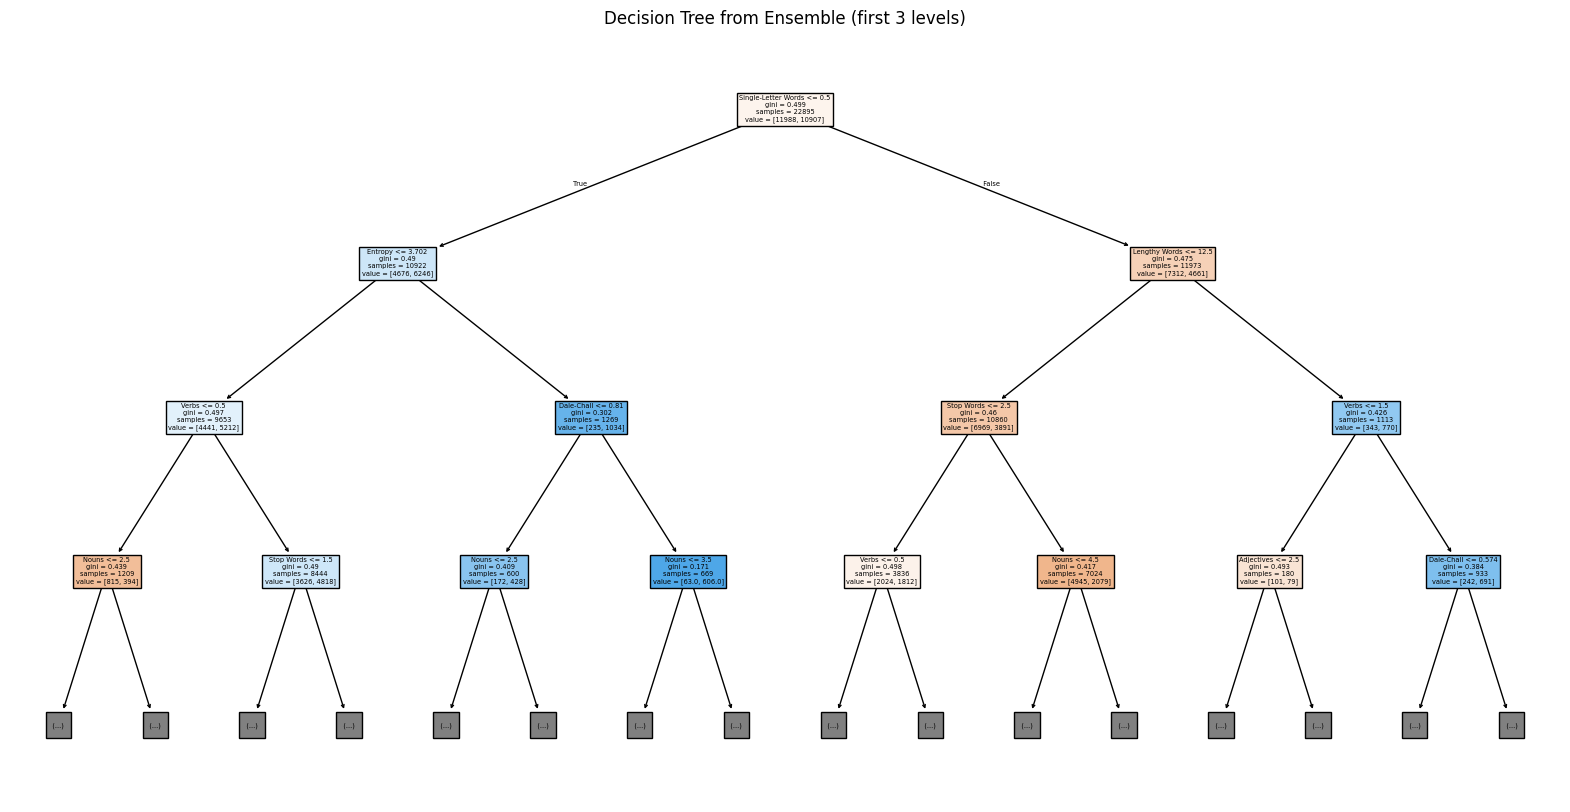

In [138]:
DecisionTreeClassifier = DecisionTreeClassifier(random_state=42)
pipeline = Pipeline([
    ('clean', cleaner_transformer),
    ('features', feature_transformer),
    ('classifier', DecisionTreeClassifier)
])

best_dt_model = pipeline.fit(X_train, y_train)

def show_metrics(model, X, y, label_str):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    print(f"{label_str} metrics:")
    print("Accuracy = {:.4f}".format(acc))
    print("F1 Score = {:.4f}".format(f1))
    print(classification_report(y, y_pred))
    print("-" * 50)

show_metrics(best_dt_model, X_train, y_train, "Best Model Training Set")
show_metrics(best_dt_model, X_test, y_test, "Best Model Test Set")

# Visualize Portion of the Decision Tree
dt = best_dt_model.named_steps['classifier']
plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, max_depth=3, feature_names=[
    'Entropy', 'Lexical Diversity', 'Dale-Chall', 'Flesch Ease', 'Stop Words',
    'Wrong Words', 'Difficult Words', 'Lengthy Words', 'Two-Letter Words',
    'Single-Letter Words', 'Verbs', 'Adjectives', 'Nouns', 'Negation_count',
            'intensifier_count',
            'downtoner_count',
            'exclam_count',
            'question_count',
            'sentiment',
            'contrast_count',
            'avg_word_length',
            'sentiment_disparity',
            'explicit_incongruity_count',   
            'largest_positive_subsequence', 
            'largest_negative_subsequence', 
            'largest_same_polarity_sequence', 
            'positive_words_count',         
            'negative_words_count',         
            'lexical_polarity',
            'sir'
])
plt.title("Decision Tree from Ensemble (first 3 levels)")
plt.show()
